In [7]:
import requests
from itertools import chain
from collections import defaultdict
import urllib
import sys
import os
from shutil import copy2
from PIL import Image
import pickle
import random
import shutil
import matplotlib

from __future__ import division

In [8]:
imgs = {}
with open('imgs.pkl') as imgs_file:
    imgs = pickle.load(imgs_file)

In [9]:
headers = {'Accept': '*/*', 
           'X-Requested-With': 'XMLHttpRequest', 
           'User-Agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Mac OS X) AppleWebKit/601.1.46 (KHTML, like Gecko) Version/9.0 Mobile/13B143 Safari/601.1', 
           'Referer': 'https://www.instagram.com/', 
           'Accept-Language': 'ru,en;q=0.8'}

In [10]:
tag_names = [
    'love', 'instagood', 'photooftheday', 'tbt', 'beautiful', 'cute', 'happy', 'fashion', 'followme', 'me', 
'follow', 'selfie', 'like4like', 'picoftheday', 'friends', 'instadaily', 'girl', 'fun', 'smile', 'repost', 
'tagsforlikes', 'art', 'instalike', 'food', 'igers', 'nature', 'family', 'style', 'likeforlike', 'instamood', 
'nofilter', 'follow4follow', 'amazing', 'life', 'fitness', 'vscocam', 'bestoftheday', 'beauty', 'sun', 
'travel', 'beach', 'followforfollow', 'music', 'sky', 'swag', 'f4f', 'l4l', 'pretty', 'vsco', 'dog', 'photo',
 'sunset', 'hair', 'foodporn', 'instagram', 'makeup', 'tflers', 'ootd', 'party', 'cat', 'lol', 'girls', 'cool',
  'baby', 'night', 'funny', 'instapic', 'healthy', 'hot', 'yummy', 'model', 'iphoneonly', 'motivation', 'gym', 
  'black', 'instacool', 'pink', 'blue', 'work', 'followback', 'webstagram', 'my', 'tweegram', 'instasize', 
  'iphonesia', 'instafollow', 'flowers', 'design', 'instalove', 'instafood', 'fit', 'sweet', 'blackandwhite', 
  'birthday', 'wedding', 'red', 'nyc', 'workout', 'christmas'
]

In [ ]:
#grep instagram
while len(imgs) < 100000:
    if len(imgs) % 1000 == 0:
        print len(imgs)
    for tag_name in tag_names:
        try:
            resp = requests.get('https://www.instagram.com/explore/tags/{}/?__a=1'.format(tag_name), 
                                headers=headers)
            tag_dict = resp.json()[u'tag']
            for node in chain(tag_dict[u'media'][u'nodes'], tag_dict[u'top_posts'][u'nodes']):
                if node[u'is_video'] == True:
                    continue
                try:
                    caption = node[u'caption']
                    image_tags = set()
                    for part in caption.split('#'):
                        if part.split():
                            image_tags.add(part.split()[0].strip())
                    imgs[node[u'thumbnail_src']] = image_tags
                except Exception, e:
                    print 1, e
        except Exception, e:
            print 2, e

In [ ]:
#download pics
error_img = []
already_downloaded = set(os.listdir('imgs'))
for i, img in enumerate(imgs):
    img_name = img.split('/')[-1]
    if img_name in already_downloaded:
        continue
    if i % 100 == 0:
        print i
    try:
        img = img.replace('https://', 'http://')
        urllib.urlretrieve(img, 'imgs/' + img_name)
    except Exception,e:
        error_img.append(img)
        print >> sys.stderr, e

In [ ]:
# clean dataset from boken images
images_done = set()
for index, img in enumerate(imgs):
    if index % 1000 == 0:
        print index
    img_name = img.split('/')[-1]
    try:
        Image.open(os.path.join('imgs', img_name)).convert('RGB')
    except Exception, e:
        print 1
        try:
            os.remove(os.path.join('imgs', img_name))
        except:
            print 2
            continue
    images_done.add(img)

In [ ]:
# save images dict
with open('imgs.pkl', 'wb') as output:
    pickle.dump(imgs, output, 2)

In [11]:
# get most popular tags
tag_counter = defaultdict(int)
for tags in imgs.itervalues():
    for tag in tags:
        tag_counter[tag] += 1


christmas_count = tag_counter['christmas']
for tag in tag_names:
    tag_counter[tag] -= christmas_count


popular_tags = set([tag for tag, count in sorted(tag_counter.items(), key=lambda x: -x[1])[:130]]) 

banned_tags = set([u'Repost', u'TagsForLikes', u'f4f', u'follow', u'follow4follow', u'followforfollow', u'followme',
               u'fashionista', u'insta', u'instacool', u'instadaily', u'instafashion', u'instafollow', u'instafood',
               u'instago', u'instagood', u'instagram', u'instalike', u'instalove', u'instamood', u'instapic', u'l4l',
               u'like', u'like4like', u'likeforfollow', u'likeforlike', u'pic', u'picoftheday', u'photo', 
               u'photooftheday',])
               
popular_tags = popular_tags - banned_tags

In [15]:
# prepare train/val folders. We need only one tag per picture, 
# so get rid of pics with multiple tags
shutil.rmtree('train', ignore_errors=True)
shutil.rmtree('val', ignore_errors=True)
for tag in popular_tags:
    for directory in ['train/' + tag, 'val/' + tag]:
        os.makedirs(directory)

already_downloaded = set(os.listdir('imgs'))
tags_counter = defaultdict(int)

for i, img in enumerate(imgs):
    if i % 10000 == 0:
        print(i)
    img_name = img.split('/')[-1]
    if img_name in already_downloaded:
        intersection = set(imgs[img]) & popular_tags
        if len(intersection) != 1:
            continue
#         tag = min(intersection, key=lambda x: tags_counter[x])
        tag = iter(intersection).next()
        tags_counter[tag] += 1
        pref = 'train'
        if tags_counter[tag] % 3 == 0:
            pref = 'val'
        copy2(os.path.join('imgs', img_name), os.path.join(pref, tag))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [16]:
# remove tags with few images
tags_counter_new = {}
for tag, count in tags_counter.iteritems():
    if count < 100:
        shutil.rmtree('train/' + tag)
        shutil.rmtree('val/' + tag)
    else:
        tags_counter_new[tag] = count

print(len(tags_counter_new))
print(sum(tags_counter_new.values()))

65
19809


In [17]:
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()   # interactive mode


# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './'
batch_size = 4
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = np.array(dsets['train'].classes)

use_gpu = torch.cuda.is_available()

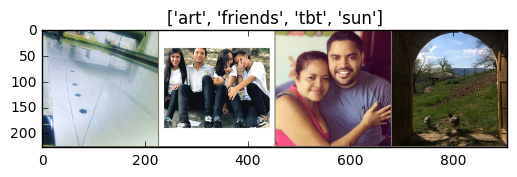

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

In [25]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.
            running_corrects = 0
            
            batch_loss = 0.
            batch_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dset_loaders[phase]):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                
                stat_size = 100
                batch_loss += loss.data[0]
                batch_corrects += torch.sum(preds == labels.data)
                if i % stat_size + 1 == stat_size:
                    print('   ', phase, 
                          batch_loss / stat_size / batch_size, 
                          batch_corrects / stat_size / batch_size)
                    batch_loss = 0
                    batch_corrects = 0

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            with open('output.log', 'a') as out_file:
                out_file.write('{} Loss: {:.4f} Acc: {:.4f}\n'.format(
                    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_loss
                best_model = copy.deepcopy(model)
                with open('model_conv_epoch' + str(epoch), 'wb') as output:
                    pickle.dump(model, output, 2)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    with open('output.log', 'a') as out_file:
        out_file.write('Training complete in {:.0f}m {:.0f}s\n'.format(
            time_elapsed // 60, time_elapsed % 60))
        out_file.write('Best val Acc: {:4f}'.format(best_acc))
    return best_model

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

def softmax(w):
    e = torch.exp(w)
    dist = e / torch.sum(e)
    return dist

def visualize_model(model, num_images=60):
    images_so_far = 0
    fig = plt.figure(figsize=(20, num_images / 2))

    for i, data in enumerate(dset_loaders['val']):
        if i > 100:
            return
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        sorted_elems, indexes = torch.sort(outputs.data, dim=1, descending=True)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//4, 8, 2 * images_so_far - 1)
            ax.axis('off')
            real_class = dset_classes[labels.data[j]]
            ax.set_title(real_class)            
            imshow(inputs.cpu().data[j])
            
            ax = plt.subplot(num_images//4, 8, 2 * images_so_far)
            objects = dset_classes[indexes[j,:5].cpu().numpy()]
            ax.barh(range(5), softmax(sorted_elems[j,:5]).cpu().numpy(), align='center', alpha=0.5)
            plt.tight_layout()
            plt.gca().invert_yaxis()
            plt.yticks(range(5), objects)
            barlist=filter(lambda x: isinstance(x, matplotlib.patches.Rectangle), ax.get_children())
            for bar_index, bar in enumerate(barlist[:-1]):
                if objects[bar_index] == real_class:
                    bar.set_color('g')
                    break
            ax.set_xlim([0, 1])

            if images_so_far == num_images:
                return

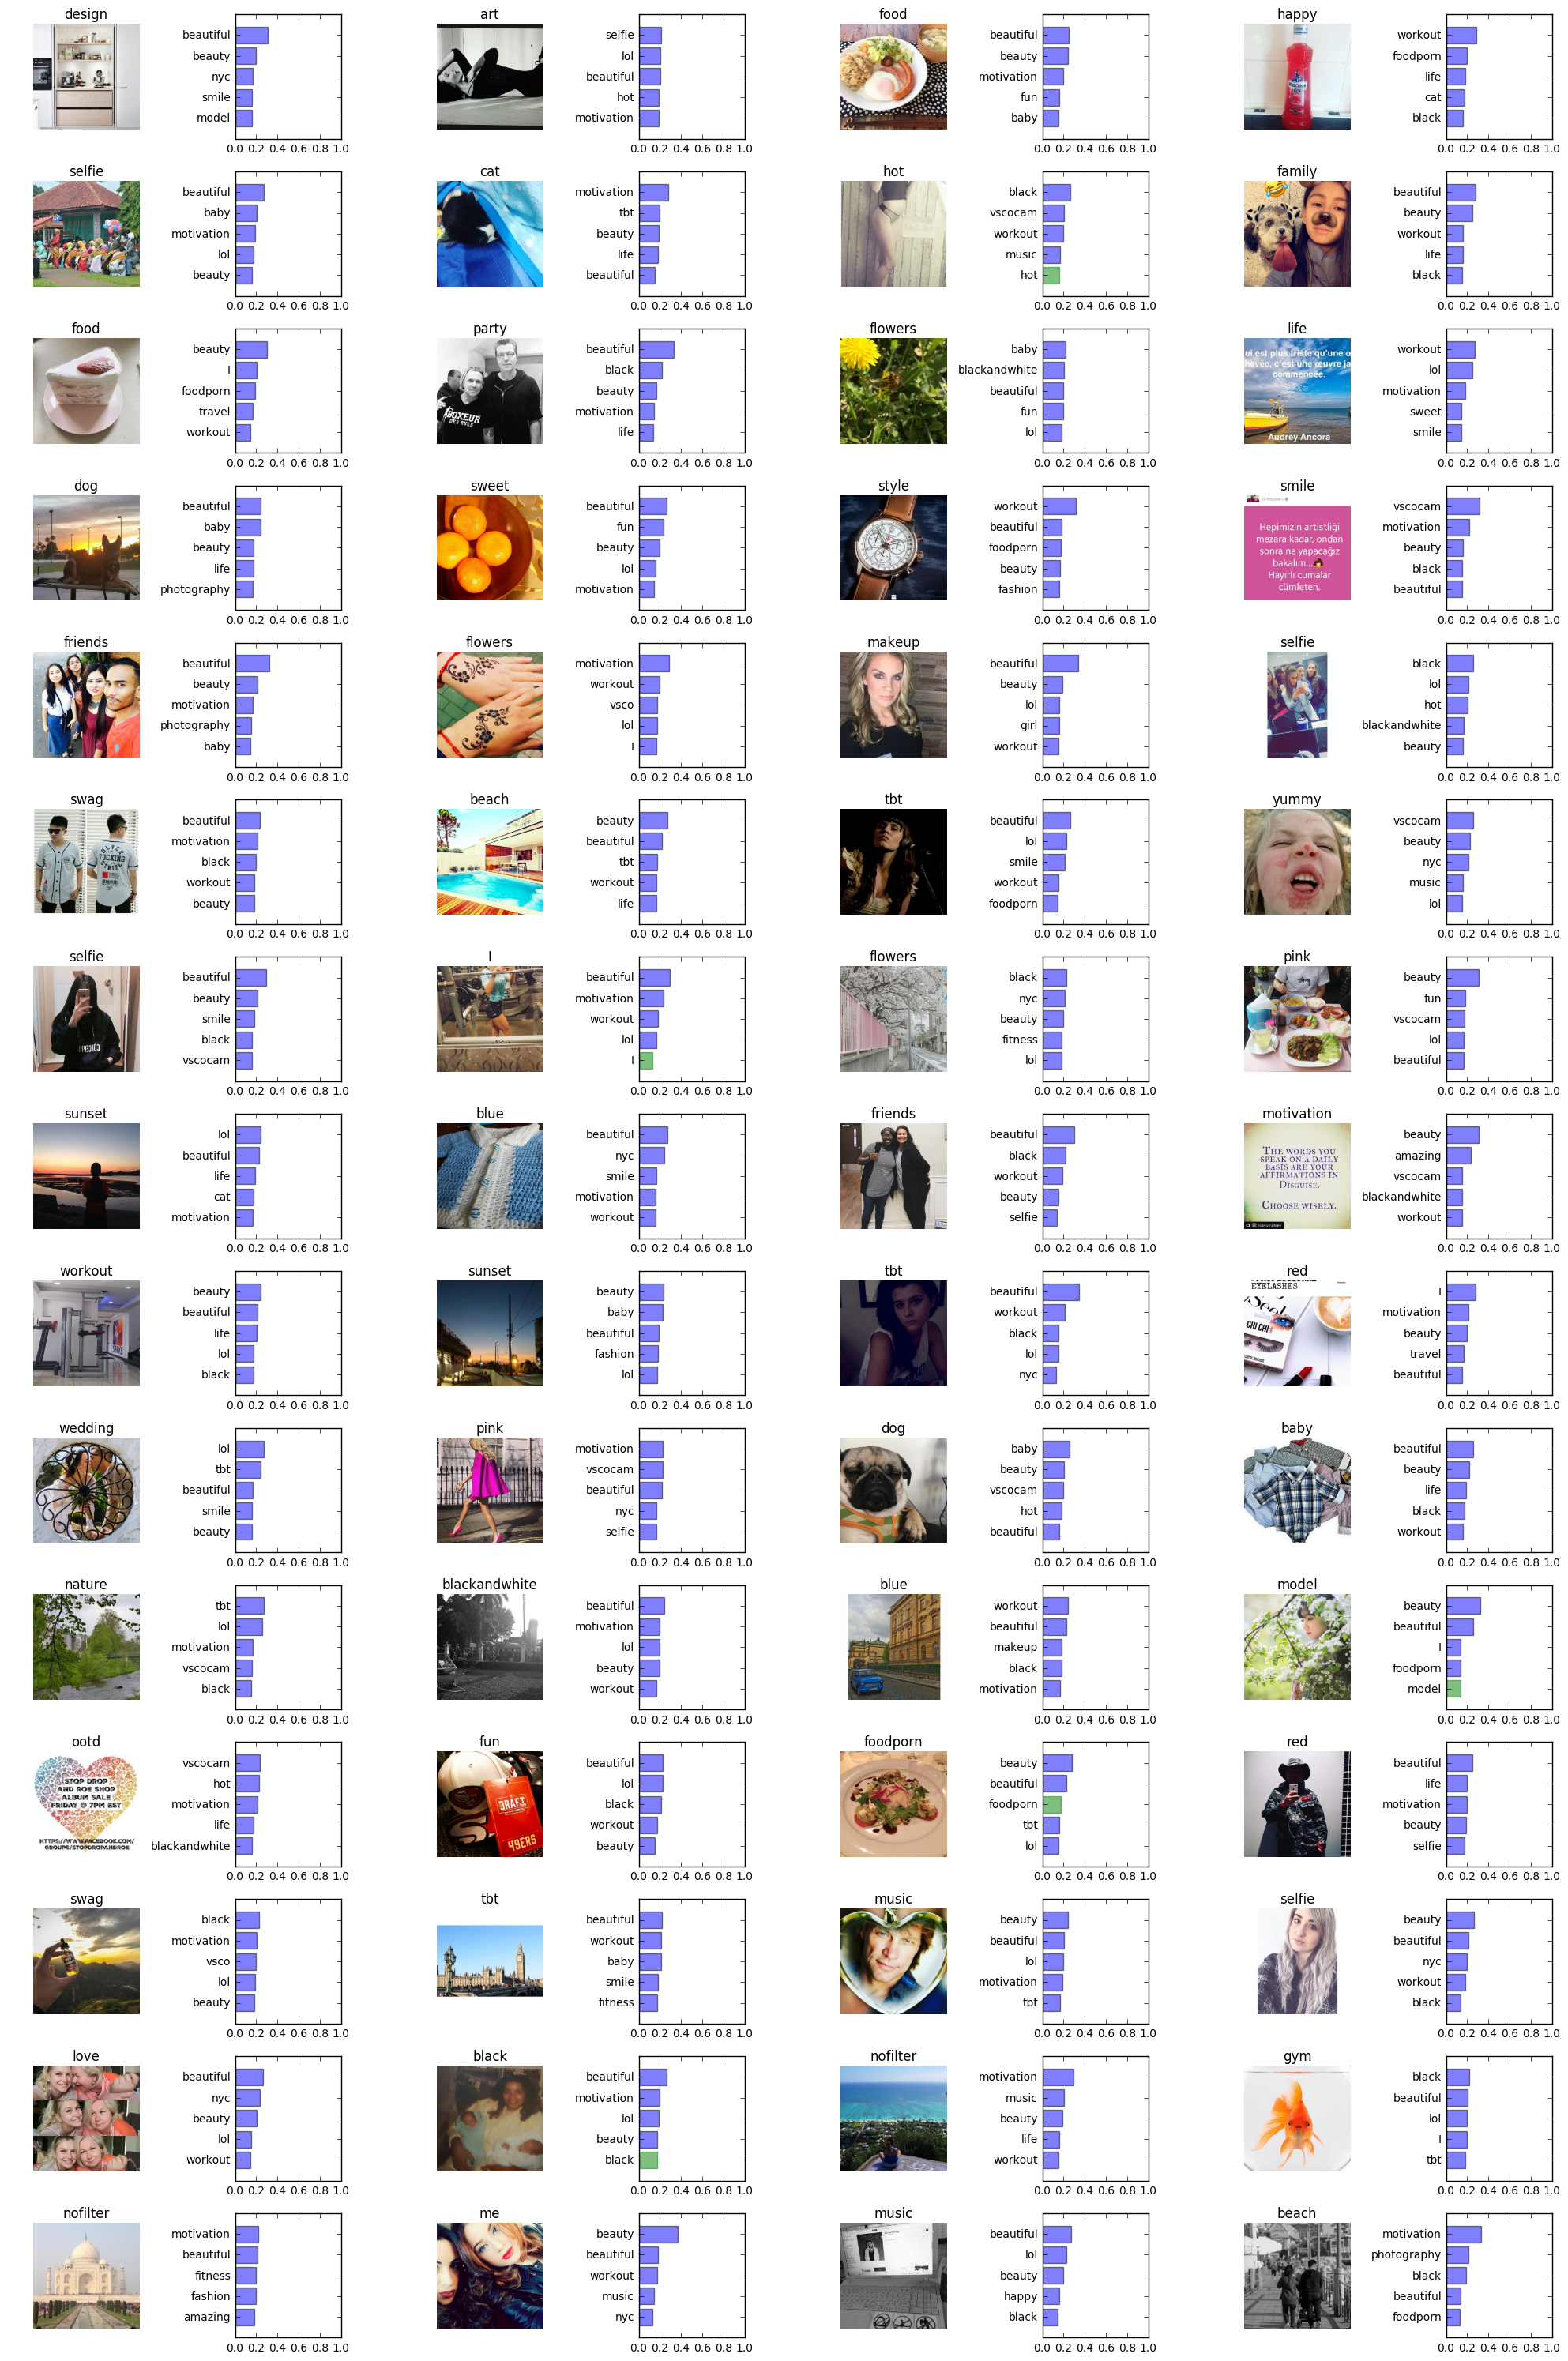

In [23]:
visualize_model(model_conv, 60)

In [20]:
# Set up NN
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(tags_counter_new))

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# RUN NN, RUN!
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1)
with open('model_conv', 'wb') as output:
    pickle.dump(model_conv, output, 2)

Epoch 0/0
----------
LR is set to 0.001
    train 1.05461483896 0.0325
    train 1.0234677732 0.0725
    train 1.02964960992 0.0875
    train 1.01763900578 0.07
    train 0.985399334431 0.1
    train 0.94457244128 0.125
    train 0.961304340363 0.1475
    train 0.961189514995 0.1275
    train 0.958611266613 0.14
    train 0.980249618292 0.11
    train 0.90811095953 0.17
    train 0.941997357607 0.1375
    train 0.938002166748 0.1475
    train 0.928296754956 0.1575
    train 0.922337128222 0.145
    train 0.925032074451 0.135
    train 0.931098300219 0.145
    train 0.945037844479 0.1525
    train 0.94689716965 0.145
    train 0.941352300644 0.15
    train 0.905986986756 0.1575
    train 0.9382602337 0.165
    train 0.922203884721 0.1625
    train 0.933442063928 0.14
    train 0.924556910694 0.13
    train 0.880424017906 0.195
    train 0.900730355382 0.1325
    train 0.921951624453 0.1625
    train 0.896827535033 0.16
    train 0.907215295434 0.1775


In [ ]:
with open('model_conv', 'wb') as output:
    pickle.dump(model_conv, output, 2)